In [150]:
import numpy as np
from os.path import join
import json
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr,spearmanr,percentileofscore
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [15]:
txtvizdir = join('txtviz','bert-base-uncased_test')

In [122]:
vectors = np.load(join(txtvizdir,'all_layer_11_vectors.npz'))
vectors = vectors['vectors']

with open(join(txtvizdir,'all_token_info.json')) as f:
        token_info = json.load(f)

with open(join(txtvizdir,'all_contexts.json')) as f:
        context_info = json.load(f)
        
with open(join('txtviz','metadata','all.json')) as f:
        doc_info = json.load(f)

with open(join('txtviz','counts','all_test_token_counts_all.json')) as f:
        count_info = json.load(f)

In [132]:
target_words = ['bank','commerce','publicuse','naturalborn','35']

In [134]:
#eval_reps = defaultdict(list) # want all evans from 1640 - 1810
eval_reps = defaultdict(list) # want all evans and founders from 1700 - 1810
for i,v in enumerate(vectors):
    #get doc name
    d = token_info['segments'][i].split('_')[0]
    source = doc_info[d]['source']
    decade = doc_info[d]['decade']
    ## check for evans
    #if source == "Evans Early American Imprints" and (1640 <= decade <= 1810):
    #    t = tokens['tokens'][i]
    #    eval_reps[t].append(v)
    
    # check for evans v founders
    if (source == "Evans Early American Imprints" or source == "National Archives Founders Online") and (1710 <= decade <= 1810):
        t = tokens['tokens'][i]
        eval_reps[t].append(v)
     

In [109]:
min_samples = 10 # need a certain ratio of examples in each cluster min 4 in each cluster

In [144]:
eval_scores = {}
target_labels = {}
for token in eval_reps:
    if len(eval_reps[token])> min_samples:
        # cluster into two clusters
        X = np.array(eval_reps[token])
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
        # check if there are at least 4 items in each cluster
        c1 = 0
        for x in kmeans.labels_:
            if x == 0:
                c1 += 1
                
        if c1 >= 4 or token in target_words:
            # sihouette score
            eval_scores[token] = silhouette_score(X, kmeans.labels_)
        
        if token in target_words:
            # save the clustering labels
            target_labels[token] = kmeans.labels_

[]

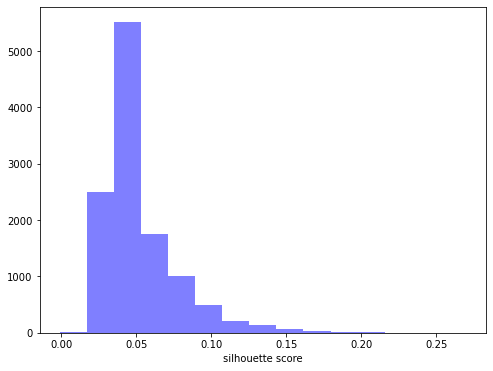

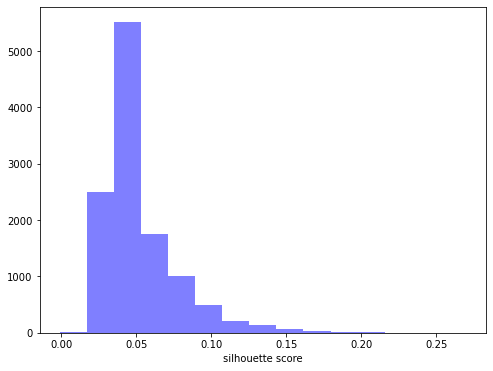

In [146]:
# Histogram of scores
eval_x = [eval_scores[x] for x in eval_scores]
num_bins  = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('silhouette score')
n, bins, patches = ax.hist(eval_x, num_bins, facecolor='blue', alpha=0.5)
# plt.title(r' Silhouette Score Histogram for evans')
#plt.savefig('eval_silhouette_hist')
plt.plot()


[]

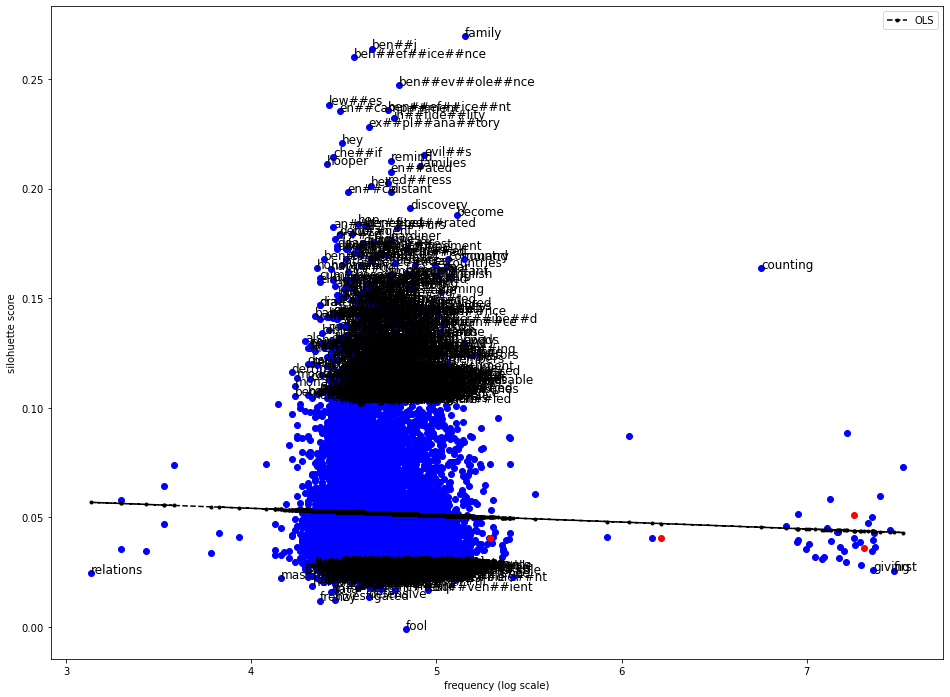

In [147]:
# Scatterplot of frequecny
eval_words = [x for x in eval_scores]
eval_freq = np.log([len(eval_reps[x]) for x in eval_words])
model = sm.OLS(eval_x, sm.add_constant(eval_freq))
results = model.fit()
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(eval_freq,results.fittedvalues, 'k--.', label="OLS")
ax.legend(loc='best')

top = np.percentile(eval_x,95)
bottom = np.percentile(eval_x,5)
bottom_five = np.percentile(eval_x,5)
target_x = []
target_y = []
x = []
y = []
for i, word in enumerate(eval_words):
    if word in target_words:
        target_x.append(eval_freq[i])
        target_y.append(eval_scores[word])
    else:
        x.append(eval_freq[i])
        y.append(eval_scores[word])
        
ax.scatter(x, y,color ='blue')        
ax.scatter(target_x, target_y,color ='red')
ax.set_ylabel('silohuette score')
ax.set_xlabel('frequency (log scale)')
top_eval_target = []

for i, word in enumerate(eval_words):
    if eval_x[i] >= top or eval_x[i]<= bottom:
        ax.annotate(word, (eval_freq[i], eval_x[i]),fontsize=12)
    if word in target_words and eval_x[i] <= bottom_five:
        top_eval_target.append(word)

plt.plot()

In [131]:
# searching for tokens
token_set = sorted(set(tokens['tokens']))
for i in token_set:
    if i[0] == 'n':
        print(i)

n
n##b
n##d
na
na##l
na##vi##gating
na##vir##e
nail
nailed
nails
naked
naked##ness
nam
name
named
namely
names
naming
nan
nan##tucket
nancy
nantes
naples
napoleon
narration
narrative
narrow
narrowly
nash
nat
nat##che##z
nat##h
nat##ivity
nathan
nathan##ael
nathaniel
nation
national
nations
native
natives
natural
natural##ization
naturalborn
naturalized
naturally
nature
nature##d
nature##s
naval
navigable
navigate
navigation
navy
nay
nay##s
nazareth
nc
nc##e
ne
ne##buch##ad##ne##zza##r
ne##gle
ne##gle##a
ne##gled
ne##gli##gent
ne##go##cia##te
ne##go##ciation
ne##go##ciation##s
ne##hem##iah
ne##r
ne##ral
ne##uf##ville
near
nearer
nearest
nearly
neat
neat##ness
neatly
nec
nec##ef##lary
nec##ess##aire
nec##ess##aries
nec##ess##ities
necessarily
necessary
necessaryandproper
necessitated
necessity
neck
neck##er
necks
ned
need
need##ful
needed
needle
needles##s
needs
needy
negative
negative##d
neglect
neglect##ing
neglect##s
neglected
negligence
negotiate
negotiated
negotiating
negotiation
ne

In [151]:
for token in target_labels:
    print(token)
    print(eval_scores[token],end='\t')
    print('percentile: '+ str(percentileofscore(eval_x,eval_scores[token])))
    # silhouette score on the clusters

bank
0.051322144	percentile: 65.95110316040548
commerce
0.036212794	percentile: 25.15546469034841
naturalborn
0.04083237	percentile: 40.335633358889176
publicuse
0.04067195	percentile: 39.875628247721274


In [ ]:
# silhouette score on the clusters
for token in target_labels: